In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

# Load the saved CSV file
data1 = pd.read_csv('./Data/uniform.csv')
data2 = pd.read_csv('./Data/constant.csv')

data = pd.concat([data1, data2], axis=0, ignore_index=True)


In [2]:
data

,X_Start,Y_Start,X_End,Y_end,Z,Power,meanLineIntensity,varLineIntensity,meanNumPixels15,varNumPixels15,meanNumPixels30,varNumPixels30,meanNumPixels60,varNumPixels60,meanNumPixels90,varNumPixels90,meanNumPixels120,varNumPixels120,medianMLength15,varMLength15,medianMLength30,varMLength30,medianMLength60,varMLength60,medianMLength90,varMLength90,medianMLength120,varMLength120,Overhang,Wall,d_edge_left,d_edge_right,d_over_left,d_over_right,d_col,d_over_z,NoLines,prev_medianMLength15,prev_medianMLength30,prev_medianMLength60,prev_meanNumPixels15,prev_meanNumPixels30,prev_meanNumPixels60,prev_meanLineIntensity
0,0,0.05,1.5,0.05,0.05,128,2.088922e+06,1.786568e+10,6358.028986,1.958660e+06,1730.202899,3.815145e+05,929.681159,91696.955669,671.086957,37658.904092,537.275362,21276.526002,74,311.666667,67,155.297101,44,25.881500,36,32.322677,32,29.053708,0,0,0.05,3.30,3.3,3.3,0.0,1.7,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00
1,0,0.10,1.5,0.10,0.05,165,2.226159e+06,1.575782e+10,8444.579710,3.505863e+06,2795.565217,6.502044e+05,1451.115942,99142.398124,958.695652,41305.744246,728.811594,17710.419864,80,206.620631,64,143.213981,47,53.272805,37,46.018329,32,34.826513,0,0,0.05,3.25,3.3,3.3,0.0,1.7,2.0,74.0,67.0,44.0,6358.028986,1730.202899,929.681159,2.088922e+06
2,0,0.15,1.5,0.15,0.05,155,2.091854e+06,5.484289e+09,7580.304348,1.264777e+06,1923.173913,1.059719e+05,907.072464,14012.979966,605.289855,8978.238278,456.159420,5754.430094,78,84.391731,59,25.041347,39,33.973572,28,32.447570,23,12.332481,0,0,0.10,3.20,3.3,3.3,0.0,1.7,3.0,80.0,64.0,47.0,8444.579710,2795.565217,1451.115942,2.226159e+06
3,0,0.20,1.5,0.20,0.05,150,2.027191e+06,6.999938e+09,6090.057971,1.417885e+06,1476.565217,7.014069e+04,778.463768,7440.987639,548.840580,3556.371270,428.956522,2568.277494,64,53.106564,51,18.705030,33,12.002984,25,5.381500,22,4.780477,0,0,0.15,3.15,3.3,3.3,0.0,1.7,4.0,78.0,59.0,39.0,7580.304348,1923.173913,907.072464,2.091854e+06
4,0,0.25,1.5,0.25,0.05,141,1.910325e+06,2.196218e+09,4565.376812,3.751401e+05,926.478261,6.390900e+03,496.695652,3254.861893,366.811594,1528.066922,294.405797,972.303495,52,23.956948,40,7.535806,25,2.847826,20,2.835465,17,2.494885,0,0,0.20,3.10,3.3,3.3,0.0,1.7,5.0,64.0,51.0,33.0,6090.057971,1476.565217,778.463768,2.027191e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,0,3.15,1.5,3.15,0.45,180,2.249554e+06,1.558428e+10,11632.573034,4.975069e+06,3346.382022,1.552949e+06,1165.415730,231232.791113,756.842697,52753.702247,569.089888,20651.128192,93,518.724464,68,341.004086,37,126.201736,30,36.477017,26,17.082227,0,0,3.10,0.20,3.3,3.3,0.0,1.7,63.0,91.0,65.0,38.0,10422.797753,3318.775281,1260.764045,2.218170e+06
3931,0,3.20,1.5,3.20,0.45,180,2.306256e+06,9.936530e+09,13062.752809,2.042073e+06,3925.303371,1.252604e+06,1273.000000,99755.795455,831.022472,15277.794944,650.752809,5695.779111,85,654.251277,64,359.601634,38,50.806946,30,23.387640,26,9.408580,0,0,3.15,0.15,3.3,3.3,0.0,1.7,64.0,93.0,68.0,37.0,11632.573034,3346.382022,1165.415730,2.249554e+06
3932,0,3.25,1.5,3.25,0.45,180,2.410141e+06,4.662493e+10,14760.303371,1.627713e+07,4803.258427,4.733781e+06,1401.123596,306540.382278,828.101124,43435.251021,646.842697,25976.134065,73,607.631001,59,418.704801,40,98.536261,31,53.566139,26,38.933861,0,0,3.20,0.10,3.3,3.3,0.0,1.7,65.0,85.0,64.0,38.0,13062.752809,3925.303371,1273.000000,2.306256e+06
3933,0,3.30,1.5,3.30,0.45,180,2.653688e+06,5.783363e+10,17459.303371,1.806368e+07,7071.550562,7.292520e+06,2286.606742,951646.582227,1232.741573,214021.762002,949.988764,99826.783963,91,908.128192,74,853.690501,55,211.740041,43,73.569459,36,25.218590,0,0,3.25,0.05,3.3,3.3,0.0,1.7,66.0,73.0,59.0,40.0,14760.303371,4803.258427,1401.123596,2.410141e+06


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Define target and input variables
target_cols = [
    'medianMLength30', 
    'meanLineIntensity'
]

input_cols = ['prev_medianMLength30', 'd_edge_right', 'prev_meanLineIntensity', 'Z', 'Power']

# Extract features and targets
X = data[input_cols].values
y = data[target_cols].values

# Create a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to prepare data loaders for a specific fold
def prepare_fold_data(X, y, train_idx, val_idx, batch_size=32):
    # Always use StandardScaler for features
    scaler = StandardScaler()
    scaler_y = StandardScaler()  
    
    # Scale features
    X_train = scaler.fit_transform(X[train_idx])
    X_val = scaler.transform(X[val_idx])
    
    # Scale targets
    y_train = scaler_y.fit_transform(y[train_idx])
    y_val = scaler_y.transform(y[val_idx])
    
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    # Create data loaders with larger batch size
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, val_loader, scaler, scaler_y

# Set up K-Fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store fold indices for later use
fold_indices = []
for train_idx, val_idx in kf.split(X):
    fold_indices.append((train_idx, val_idx))



Training Fold 1
--------------------------------------------------
Total Parameters: 1,580,034
Epoch [10/10000], Train Loss: 0.622755, Val Loss: 0.600426
Epoch [20/10000], Train Loss: 0.495203, Val Loss: 0.495690
Epoch [30/10000], Train Loss: 0.454851, Val Loss: 0.462325
Epoch [40/10000], Train Loss: 0.431338, Val Loss: 0.445331
Epoch [50/10000], Train Loss: 0.419550, Val Loss: 0.437480
Epoch [60/10000], Train Loss: 0.412440, Val Loss: 0.433269
Epoch [70/10000], Train Loss: 0.406743, Val Loss: 0.430424
Epoch [80/10000], Train Loss: 0.405161, Val Loss: 0.428348
Epoch [90/10000], Train Loss: 0.402202, Val Loss: 0.427983
Epoch [100/10000], Train Loss: 0.399647, Val Loss: 0.425103
Epoch [110/10000], Train Loss: 0.395622, Val Loss: 0.424659
Epoch [120/10000], Train Loss: 0.394306, Val Loss: 0.422692
Epoch [130/10000], Train Loss: 0.392404, Val Loss: 0.421671
Epoch [140/10000], Train Loss: 0.388726, Val Loss: 0.420898
Epoch [150/10000], Train Loss: 0.387742, Val Loss: 0.419530
Epoch [160/10

Epoch [1360/10000], Train Loss: 0.257143, Val Loss: 0.370735
Epoch [1370/10000], Train Loss: 0.261146, Val Loss: 0.370181
Epoch [1380/10000], Train Loss: 0.257704, Val Loss: 0.372038
Epoch [1390/10000], Train Loss: 0.262067, Val Loss: 0.371160
Epoch [1400/10000], Train Loss: 0.262037, Val Loss: 0.373630
Epoch [1410/10000], Train Loss: 0.261125, Val Loss: 0.376618
Epoch [1420/10000], Train Loss: 0.256437, Val Loss: 0.371116
Epoch [1430/10000], Train Loss: 0.257894, Val Loss: 0.376412
Epoch [1440/10000], Train Loss: 0.257256, Val Loss: 0.370273
Epoch [1450/10000], Train Loss: 0.254014, Val Loss: 0.372710
Epoch [1460/10000], Train Loss: 0.256185, Val Loss: 0.372856
Epoch [1470/10000], Train Loss: 0.255329, Val Loss: 0.373899
Epoch [1480/10000], Train Loss: 0.252265, Val Loss: 0.371799
Epoch [1490/10000], Train Loss: 0.252561, Val Loss: 0.372087
Epoch [1500/10000], Train Loss: 0.250142, Val Loss: 0.374072
Epoch [1510/10000], Train Loss: 0.256945, Val Loss: 0.372402
Epoch [1520/10000], Trai

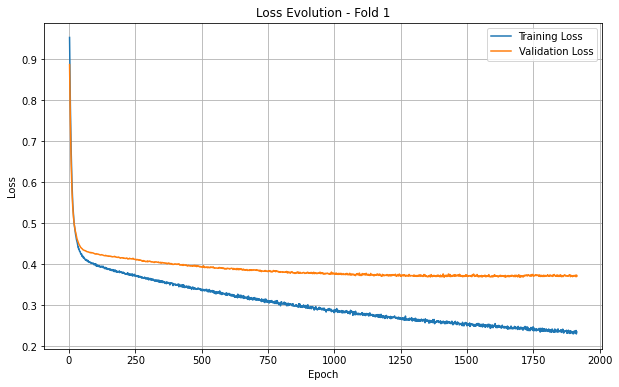

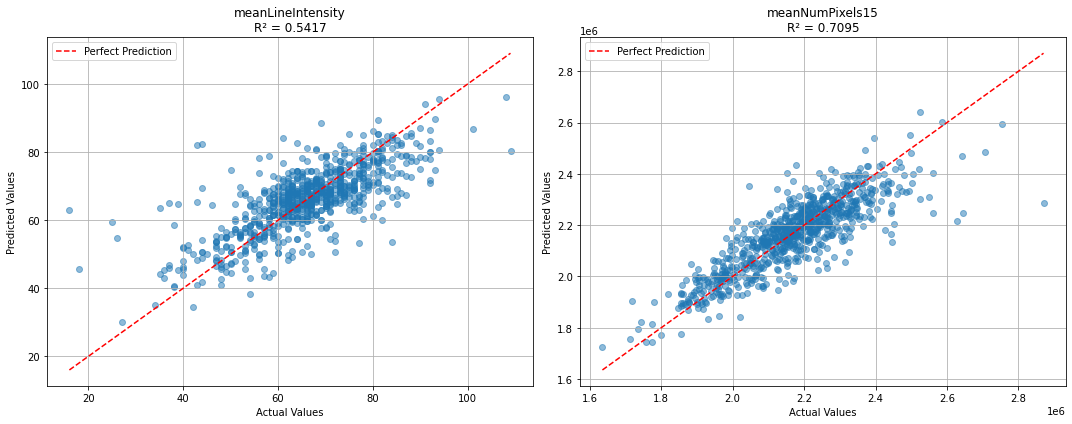


Evaluation Metrics:
MSE: 3696915598.1499
R² (meanLineIntensity): 0.5417
R² (meanNumPixels15): 0.7095
Fold 1 Validation MSE: 3696915598.1499
Fold 1 R² scores: ['0.5417', '0.7095']

Training Fold 2
--------------------------------------------------
Total Parameters: 1,580,034
Epoch [10/10000], Train Loss: 0.631824, Val Loss: 0.624139
Epoch [20/10000], Train Loss: 0.498470, Val Loss: 0.493484
Epoch [30/10000], Train Loss: 0.460751, Val Loss: 0.463306
Epoch [40/10000], Train Loss: 0.439627, Val Loss: 0.445751
Epoch [50/10000], Train Loss: 0.428794, Val Loss: 0.435744
Epoch [60/10000], Train Loss: 0.422467, Val Loss: 0.430820
Epoch [70/10000], Train Loss: 0.416325, Val Loss: 0.427922
Epoch [80/10000], Train Loss: 0.413067, Val Loss: 0.425223
Epoch [90/10000], Train Loss: 0.410428, Val Loss: 0.422300
Epoch [100/10000], Train Loss: 0.405855, Val Loss: 0.421054
Epoch [110/10000], Train Loss: 0.405501, Val Loss: 0.420451
Epoch [120/10000], Train Loss: 0.402854, Val Loss: 0.418922
Epoch [130/10

Epoch [1330/10000], Train Loss: 0.266555, Val Loss: 0.370310
Epoch [1340/10000], Train Loss: 0.266452, Val Loss: 0.372233
Epoch [1350/10000], Train Loss: 0.267229, Val Loss: 0.369103
Epoch [1360/10000], Train Loss: 0.267398, Val Loss: 0.369679
Epoch [1370/10000], Train Loss: 0.265955, Val Loss: 0.370850
Epoch [1380/10000], Train Loss: 0.263296, Val Loss: 0.374800
Epoch [1390/10000], Train Loss: 0.263639, Val Loss: 0.369920
Epoch [1400/10000], Train Loss: 0.260291, Val Loss: 0.370169
Epoch [1410/10000], Train Loss: 0.260020, Val Loss: 0.370356
Epoch [1420/10000], Train Loss: 0.264151, Val Loss: 0.369750
Epoch [1430/10000], Train Loss: 0.260365, Val Loss: 0.370149
Epoch [1440/10000], Train Loss: 0.263343, Val Loss: 0.370640
Epoch [1450/10000], Train Loss: 0.260270, Val Loss: 0.369638
Epoch [1460/10000], Train Loss: 0.263426, Val Loss: 0.370484
Epoch [1470/10000], Train Loss: 0.256522, Val Loss: 0.370308
Epoch [1480/10000], Train Loss: 0.256627, Val Loss: 0.370460
Epoch [1490/10000], Trai

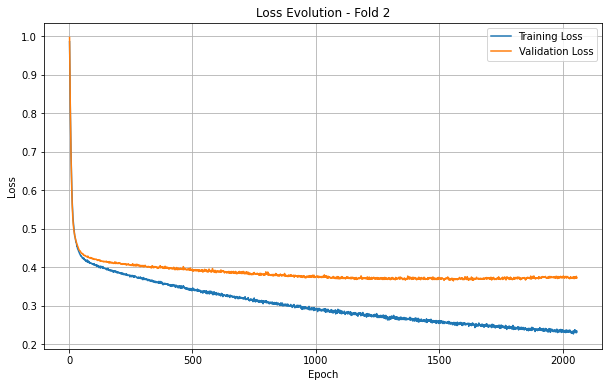

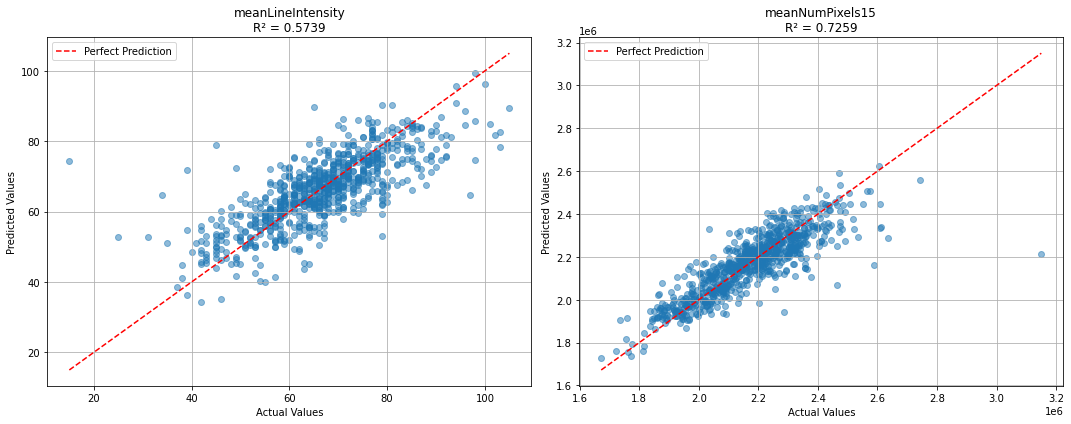


Evaluation Metrics:
MSE: 3842013107.5578
R² (meanLineIntensity): 0.5739
R² (meanNumPixels15): 0.7259
Fold 2 Validation MSE: 3842013107.5578
Fold 2 R² scores: ['0.5739', '0.7259']

Training Fold 3
--------------------------------------------------
Total Parameters: 1,580,034
Epoch [10/10000], Train Loss: 0.652387, Val Loss: 0.575889
Epoch [20/10000], Train Loss: 0.498196, Val Loss: 0.457444
Epoch [30/10000], Train Loss: 0.460078, Val Loss: 0.428248
Epoch [40/10000], Train Loss: 0.438490, Val Loss: 0.409056
Epoch [50/10000], Train Loss: 0.426634, Val Loss: 0.401649
Epoch [60/10000], Train Loss: 0.420069, Val Loss: 0.396674
Epoch [70/10000], Train Loss: 0.411784, Val Loss: 0.392477
Epoch [80/10000], Train Loss: 0.410327, Val Loss: 0.391875
Epoch [90/10000], Train Loss: 0.405005, Val Loss: 0.390884
Epoch [100/10000], Train Loss: 0.403090, Val Loss: 0.388275
Epoch [110/10000], Train Loss: 0.400053, Val Loss: 0.386852
Epoch [120/10000], Train Loss: 0.396388, Val Loss: 0.386049
Epoch [130/10

Epoch [1330/10000], Train Loss: 0.260349, Val Loss: 0.373961
Epoch [1340/10000], Train Loss: 0.261096, Val Loss: 0.371468
Epoch [1350/10000], Train Loss: 0.257767, Val Loss: 0.371988
Epoch [1360/10000], Train Loss: 0.259511, Val Loss: 0.372484
Epoch [1370/10000], Train Loss: 0.260523, Val Loss: 0.370640
Epoch [1380/10000], Train Loss: 0.255454, Val Loss: 0.374113
Epoch [1390/10000], Train Loss: 0.255671, Val Loss: 0.371187
Early stopping triggered at epoch 1396


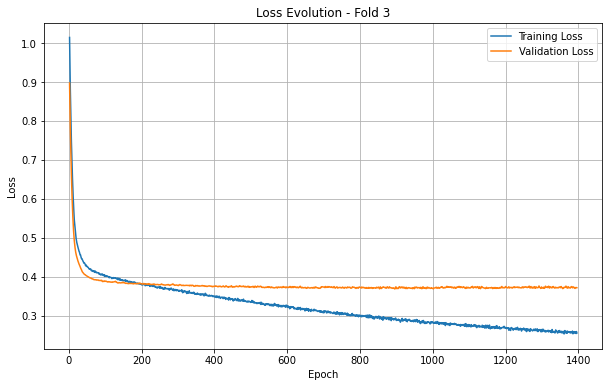

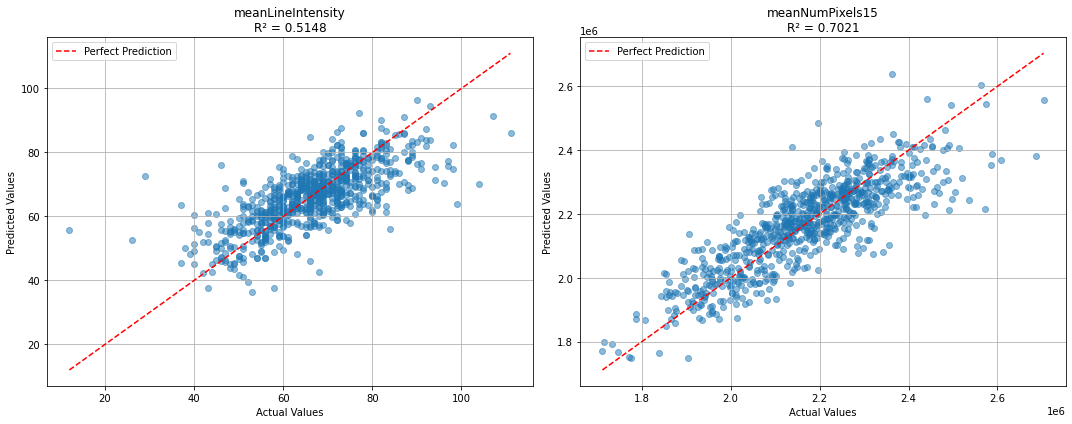


Evaluation Metrics:
MSE: 3712642036.6150
R² (meanLineIntensity): 0.5148
R² (meanNumPixels15): 0.7021
Fold 3 Validation MSE: 3712642036.6150
Fold 3 R² scores: ['0.5148', '0.7021']

Training Fold 4
--------------------------------------------------
Total Parameters: 1,580,034
Epoch [10/10000], Train Loss: 0.581847, Val Loss: 0.569105
Epoch [20/10000], Train Loss: 0.474448, Val Loss: 0.482366
Epoch [30/10000], Train Loss: 0.444343, Val Loss: 0.450109
Epoch [40/10000], Train Loss: 0.425290, Val Loss: 0.435490
Epoch [50/10000], Train Loss: 0.415420, Val Loss: 0.427373
Epoch [60/10000], Train Loss: 0.409792, Val Loss: 0.421609
Epoch [70/10000], Train Loss: 0.407883, Val Loss: 0.418925
Epoch [80/10000], Train Loss: 0.404679, Val Loss: 0.415075
Epoch [90/10000], Train Loss: 0.401108, Val Loss: 0.412776
Epoch [100/10000], Train Loss: 0.398494, Val Loss: 0.412841
Epoch [110/10000], Train Loss: 0.396006, Val Loss: 0.411462
Epoch [120/10000], Train Loss: 0.393817, Val Loss: 0.410561
Epoch [130/10

Epoch [1330/10000], Train Loss: 0.267945, Val Loss: 0.346600
Epoch [1340/10000], Train Loss: 0.268930, Val Loss: 0.348692
Epoch [1350/10000], Train Loss: 0.265119, Val Loss: 0.346070
Epoch [1360/10000], Train Loss: 0.270014, Val Loss: 0.347504
Epoch [1370/10000], Train Loss: 0.268437, Val Loss: 0.344702
Epoch [1380/10000], Train Loss: 0.267455, Val Loss: 0.346789
Epoch [1390/10000], Train Loss: 0.267266, Val Loss: 0.347517
Epoch [1400/10000], Train Loss: 0.266675, Val Loss: 0.344337
Epoch [1410/10000], Train Loss: 0.263254, Val Loss: 0.348348
Epoch [1420/10000], Train Loss: 0.264868, Val Loss: 0.346778
Epoch [1430/10000], Train Loss: 0.261787, Val Loss: 0.347135
Epoch [1440/10000], Train Loss: 0.261313, Val Loss: 0.345364
Epoch [1450/10000], Train Loss: 0.258540, Val Loss: 0.348688
Epoch [1460/10000], Train Loss: 0.260424, Val Loss: 0.347638
Epoch [1470/10000], Train Loss: 0.261599, Val Loss: 0.346866
Epoch [1480/10000], Train Loss: 0.259098, Val Loss: 0.347178
Epoch [1490/10000], Trai

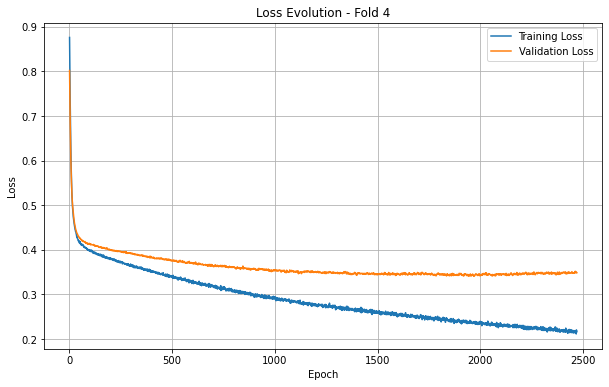

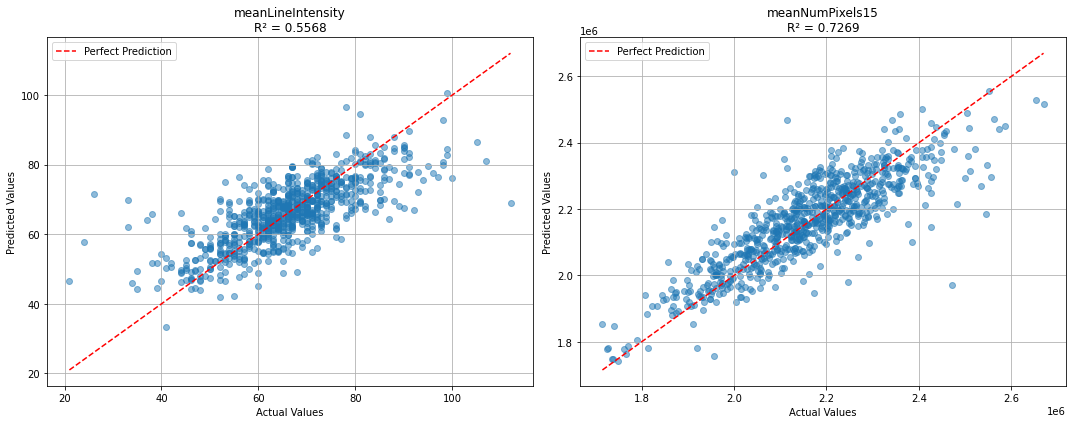


Evaluation Metrics:
MSE: 3259214358.4447
R² (meanLineIntensity): 0.5568
R² (meanNumPixels15): 0.7269
Fold 4 Validation MSE: 3259214358.4447
Fold 4 R² scores: ['0.5568', '0.7269']

Training Fold 5
--------------------------------------------------
Total Parameters: 1,580,034
Epoch [10/10000], Train Loss: 0.632769, Val Loss: 0.637317
Epoch [20/10000], Train Loss: 0.510057, Val Loss: 0.508501
Epoch [30/10000], Train Loss: 0.469036, Val Loss: 0.469213
Epoch [40/10000], Train Loss: 0.448062, Val Loss: 0.447909
Epoch [50/10000], Train Loss: 0.433864, Val Loss: 0.435312
Epoch [60/10000], Train Loss: 0.428936, Val Loss: 0.427612
Epoch [70/10000], Train Loss: 0.423483, Val Loss: 0.424911
Epoch [80/10000], Train Loss: 0.420052, Val Loss: 0.421656
Epoch [90/10000], Train Loss: 0.415466, Val Loss: 0.419476
Epoch [100/10000], Train Loss: 0.413568, Val Loss: 0.417403
Epoch [110/10000], Train Loss: 0.409523, Val Loss: 0.413361
Epoch [120/10000], Train Loss: 0.403750, Val Loss: 0.412755
Epoch [130/10

Epoch [1330/10000], Train Loss: 0.267322, Val Loss: 0.393220
Epoch [1340/10000], Train Loss: 0.258972, Val Loss: 0.391851
Epoch [1350/10000], Train Loss: 0.263226, Val Loss: 0.396138
Epoch [1360/10000], Train Loss: 0.261849, Val Loss: 0.393130
Epoch [1370/10000], Train Loss: 0.259773, Val Loss: 0.390903
Epoch [1380/10000], Train Loss: 0.258670, Val Loss: 0.393429
Epoch [1390/10000], Train Loss: 0.260612, Val Loss: 0.393483
Epoch [1400/10000], Train Loss: 0.257890, Val Loss: 0.392212
Early stopping triggered at epoch 1403


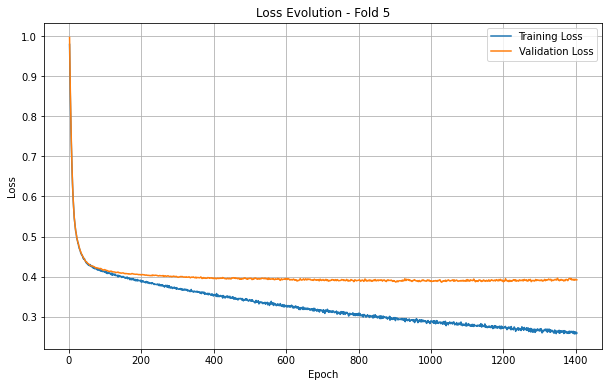

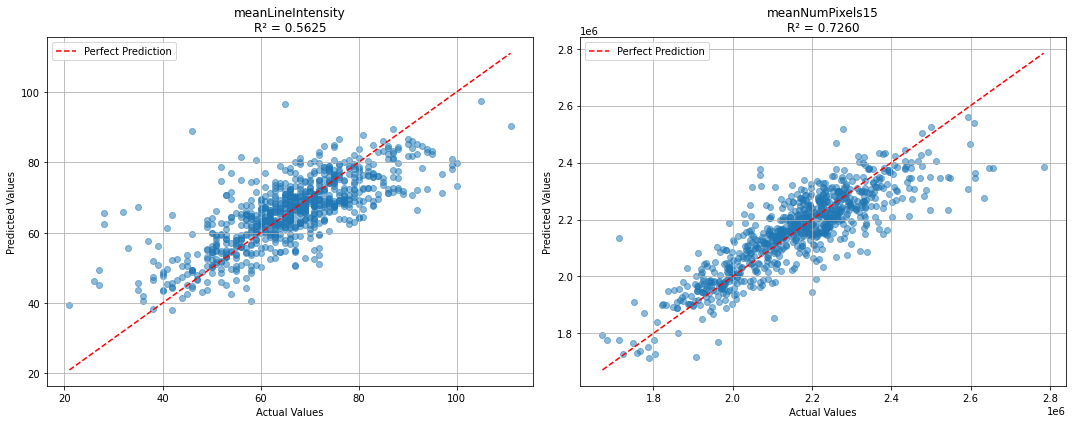


Evaluation Metrics:
MSE: 3657634586.3482
R² (meanLineIntensity): 0.5625
R² (meanNumPixels15): 0.7260
Fold 5 Validation MSE: 3657634586.3482
Fold 5 R² scores: ['0.5625', '0.7260']

Cross-validation Results:
Average MSE: 3633683937.4231 ± 197197751.8328
Average R² (meanLineIntensity): 0.5499 ± 0.0204
Average R² (meanNumPixels15): 0.7181 ± 0.0103
------------------------------

Cross-validation Results:
Average MSE: 3633683937.4231 ± 197197751.8328


In [4]:
import torch.nn as nn
import torch.optim as optim
import tqdm
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            #nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dim, dim),
            #nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual  # Skip connection
        return self.relu(out)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128, num_layers=3, output_dim=2, dropout_rate=0.2):
        super(MLPRegressor, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            #nn.Dropout(dropout_rate)
        )
        
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout_rate) 
            for _ in range(num_layers - 1)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.residual_layers:
            x = layer(x)
        return self.output_layer(x)

def print_model_params(model):
    total_params = 0
    input_params = sum(p.numel() for p in model.input_layer.parameters())
    total_params += input_params
    
    for i, block in enumerate(model.residual_layers):
        block_params = sum(p.numel() for p in block.parameters())
        total_params += block_params
    
    output_params = sum(p.numel() for p in model.output_layer.parameters())
    total_params += output_params
    
    print("-" * 50)
    print(f"Total Parameters: {total_params:,}")

def train_model(model, train_loader, val_loader, num_epochs=1000, patience=50):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    # Lists to store losses for plotting
    train_losses = []
    val_losses = []
    epochs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        # Store losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epochs.append(epoch + 1)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return best_model, train_losses, val_losses, epochs

def train_k_fold(X, y, fold_indices, hidden_dim=128, num_layers=3, batch_size=32):
    models = []
    scalers = []
    scalers_y = []
    val_scores = []
    r2_scores_all = []

    for fold, (train_idx, val_idx) in enumerate(fold_indices):
        print(f'\nTraining Fold {fold+1}')

        # Prepare data for this fold
        train_loader, val_loader, scaler, scaler_y = prepare_fold_data(
            X, y, train_idx, val_idx, batch_size
        )

        # Initialize model
        model = MLPRegressor(
            input_dim=X.shape[1],
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            output_dim=y.shape[1]
        )
        
        print_model_params(model)

        # Train model and get loss history
        best_model, train_losses, val_losses, epochs = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=10000,
            patience=500
        )

        # Plot loss evolution for this fold
        plt.figure(figsize=(10, 6))
        plt.plot(epochs[1:], train_losses[1:], label='Training Loss')
        plt.plot(epochs[1:], val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss Evolution - Fold {fold+1}')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Store the trained model and scalers
        models.append(best_model)
        scalers.append(scaler)
        scalers_y.append(scaler_y)

        # Calculate validation scores
        mse, r2_scores, predictions, actuals = evaluate_model(best_model, val_loader, scaler_y)
        val_scores.append(mse)
        r2_scores_all.append(r2_scores)
        print(f'Fold {fold+1} Validation MSE: {mse:.4f}')
        print(f'Fold {fold+1} R² scores: {[f"{r2:.4f}" for r2 in r2_scores]}')

    # Calculate and print average metrics
    print("\nCross-validation Results:")
    print(f"Average MSE: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")
    r2_scores_all = np.array(r2_scores_all)
    for i, target in enumerate(['meanLineIntensity', 'meanNumPixels15']):
        mean_r2 = np.mean(r2_scores_all[:, i])
        std_r2 = np.std(r2_scores_all[:, i])
        print(f"Average R² ({target}): {mean_r2:.4f} ± {std_r2:.4f}")
    
    return models, scalers, scalers_y, val_scores, r2_scores_all

def evaluate_model(model, data_loader, scaler_y):
    model = model.to(device)
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0

    # Lists to store predictions and actual values
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)

            # Move to CPU and convert to numpy
            outputs_np = outputs.cpu().numpy()
            y_batch_np = y_batch.cpu().numpy()

            # Inverse transform
            outputs_inv = scaler_y.inverse_transform(outputs_np)
            y_batch_inv = scaler_y.inverse_transform(y_batch_np)

            # Compute loss in original scale
            loss = criterion(torch.tensor(outputs_inv), torch.tensor(y_batch_inv))
            total_loss += loss.item() * X_batch.size(0)

            all_predictions.append(outputs_inv)
            all_actuals.append(y_batch_inv)

    # Convert lists to numpy arrays
    predictions = np.vstack(all_predictions)
    actuals = np.vstack(all_actuals)

    # Calculate MSE
    mse = total_loss / len(data_loader.dataset)

    # Calculate R2 for each target
    r2_scores = []
    for i in range(actuals.shape[1]):
        ss_res = np.sum((actuals[:, i] - predictions[:, i]) ** 2)
        ss_tot = np.sum((actuals[:, i] - np.mean(actuals[:, i])) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        r2_scores.append(r2)

    # Create plots
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    target_names = ['meanLineIntensity', 'meanNumPixels15']

    for i, (ax, target) in enumerate(zip(axes, target_names)):
        # Plot predicted vs actual
        ax.scatter(actuals[:, i], predictions[:, i], alpha=0.5)

        # Plot perfect prediction line
        min_val = min(actuals[:, i].min(), predictions[:, i].min())
        max_val = max(actuals[:, i].max(), predictions[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

        # Add labels and title
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{target}\nR² = {r2_scores[i]:.4f}')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nEvaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    for i, target in enumerate(target_names):
        print(f"R² ({target}): {r2_scores[i]:.4f}")

    return mse, r2_scores, predictions, actuals


# Train the models
models, scalers, scalers_y, val_scores, r2_scores_all = train_k_fold(X, y, fold_indices, 
                                                                     hidden_dim=512, 
                                                                     num_layers=4,
                                                                     batch_size=512)

print('---'*10)
# Print overall results
print("\nCross-validation Results:")
print(f"Average MSE: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")


In [5]:
import os
import json
import pickle
import torch
from datetime import datetime

def save_training_results(models, scalers, scalers_y, val_scores, r2_scores_all, input_cols, target_cols):
    # Create Results directory if it doesn't exist
    results_dir = "Results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Create timestamped subdirectory for this training run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}")
    os.makedirs(run_dir)
    
    # Save models
    models_dir = os.path.join(run_dir, "models")
    os.makedirs(models_dir)
    for i, model in enumerate(models):
        model_path = os.path.join(models_dir, f"model_fold_{i+1}.pt")
        torch.save(model.state_dict(), model_path)
    
    # Save scalers
    scalers_dir = os.path.join(run_dir, "scalers")
    os.makedirs(scalers_dir)
    for i, (scaler, scaler_y) in enumerate(zip(scalers, scalers_y)):
        # Save feature scaler
        scaler_path = os.path.join(scalers_dir, f"feature_scaler_fold_{i+1}.pkl")
        with open(scaler_path, 'wb') as f:
            pickle.dump(scaler, f)
        
        # Save target scaler
        scaler_y_path = os.path.join(scalers_dir, f"target_scaler_fold_{i+1}.pkl")
        with open(scaler_y_path, 'wb') as f:
            pickle.dump(scaler_y, f)
    
    # Save metrics and configuration
    metrics = {
        'input_features': input_cols,
        'target_variables': target_cols,
        'val_scores': val_scores.tolist() if isinstance(val_scores, np.ndarray) else val_scores,
        'r2_scores_all': r2_scores_all.tolist() if isinstance(r2_scores_all, np.ndarray) else r2_scores_all,
        'average_mse': float(np.mean(val_scores)),
        'mse_std': float(np.std(val_scores)),
        'average_r2_by_target': {
            target: {
                'mean': float(np.mean(r2_scores_all[:, i])),
                'std': float(np.std(r2_scores_all[:, i]))
            }
            for i, target in enumerate(target_cols)
        }
    }
    
    metrics_path = os.path.join(run_dir, "metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    print(f"\nResults saved in: {run_dir}")
    print("Saved contents:")
    print(f"- {len(models)} models")
    print(f"- {len(scalers)} feature scalers and target scalers")
    print("- Evaluation metrics and configuration")

# Call the function to save the results
save_training_results(
    models=models,
    scalers=scalers,
    scalers_y=scalers_y,  
    val_scores=val_scores,
    r2_scores_all=r2_scores_all,
    input_cols=input_cols,
    target_cols=target_cols
)


Results saved in: Results/run_20241121_131612
Saved contents:
- 5 models
- 5 feature scalers and target scalers
- Evaluation metrics and configuration


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms for each feature
for col in input_cols + target_cols:
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [ ]:
import seaborn as sns

sns.pairplot(data[input_cols + target_cols])
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

r2s = []
for fold_no, indices in enumerate(fold_indices):
    
    X_train, X_val = X[indices[0]], X[indices[1]]
    y_train, y_val = y[indices[0]], y[indices[1]]

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred, multioutput='raw_values')
    print(f'Fold:  {fold_no}')
    print(f'Linear Regression MSE: {mse:.4f}')
    print(f'Linear Regression R² scores: {r2}')
    r2s.append(r2)

r2s = np.array(r2s)
mean_score = r2s.mean(axis=0)
print(f'Cross-validation mean score {mean_score}')

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred, multioutput='raw_values')
print(f'Random Forest MSE: {mse:.4f}')
print(f'Random Forest R² scores: {r2}')
